# Assignment 2
**Hazem Mohammed Abdallah		6723**

**Ahmed Ashraf Abdelkarim		6940**

**Amr Abdelsamee Youssef		7126**


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

import gc
import pickle
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import radius_neighbors_graph
from scipy.spatial.distance import pdist, squareform
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.cluster import contingency_matrix
from sklearn.cluster import SpectralClustering
from scipy.stats import entropy

## loading data

In [ ]:
path_train = "/content/drive/MyDrive/Colab Notebooks/Pattern/projects/Assignment2/kddcup.data_10_percent.gz"
path_test = "/content/drive/MyDrive/Colab Notebooks/Pattern/projects/Assignment2/corrected.gz"

In [ ]:
columns = [str(i) for i in range(1, 43)]
data_train = pd.read_csv(path_train, compression='gzip', header=None, names=columns)
data_test = pd.read_csv(path_test, compression='gzip', header=None, names=columns)

In [ ]:
DATA_TRAIN_ROWS = data_train.shape[0]
all_data = pd.concat([data_train, data_test])
print(all_data.shape)

(805050, 42)


In [ ]:
all_data.head()

,1,2,3,4,5,6,7,8,9,10,...,33,34,35,36,37,38,39,40,41,42
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


In [ ]:
all_data.isnull().sum()

1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
30    0
31    0
32    0
33    0
34    0
35    0
36    0
37    0
38    0
39    0
40    0
41    0
42    0
dtype: int64

In [ ]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 805050 entries, 0 to 311028
Data columns (total 42 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   1       805050 non-null  int64  
 1   2       805050 non-null  object 
 2   3       805050 non-null  object 
 3   4       805050 non-null  object 
 4   5       805050 non-null  int64  
 5   6       805050 non-null  int64  
 6   7       805050 non-null  int64  
 7   8       805050 non-null  int64  
 8   9       805050 non-null  int64  
 9   10      805050 non-null  int64  
 10  11      805050 non-null  int64  
 11  12      805050 non-null  int64  
 12  13      805050 non-null  int64  
 13  14      805050 non-null  int64  
 14  15      805050 non-null  int64  
 15  16      805050 non-null  int64  
 16  17      805050 non-null  int64  
 17  18      805050 non-null  int64  
 18  19      805050 non-null  int64  
 19  20      805050 non-null  int64  
 20  21      805050 non-null  int64  
 21  22      80

### Categorical features to numerical

In [ ]:
# the columns that contain non numbers values
object_cols = all_data.select_dtypes(exclude=['number']).columns.tolist()
object_cols.pop()
object_cols

['2', '3', '4']

In [ ]:
for i in range(0,len(object_cols)):
    print("\n*column:", object_cols[i])
    print(all_data[object_cols[i]].value_counts())


*column: 2
icmp    448571
tcp     309422
udp      47057
Name: 2, dtype: int64

*column: 3
ecr_i      445752
private    189403
http       105530
smtp        17991
other        9422
            ...  
urh_i          14
tim_i          14
tftp_u          2
icmp            2
red_i           1
Name: 3, Length: 67, dtype: int64

*column: 4
SF        626819
S0        105019
REJ        68820
RSTO        1972
RSTR        1775
S3           299
SH           191
S1            84
S2            46
RSTOS0        13
OTH           12
Name: 4, dtype: int64


In [ ]:
def dataFrame_encoding(dataFrame, object_column):
    df_encoded = pd.get_dummies(dataFrame, columns=[object_column])
    return df_encoded

def dataFrame_label_encoding(dataFrame, object_column):
    lab = LabelEncoder()
    dataFrame[object_column] = lab.fit_transform(dataFrame[object_column])
    return dataFrame

In [ ]:
# data encoding (hot encoding)
for object_col in object_cols:
    all_data = dataFrame_encoding(all_data, object_col)

In [ ]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 805050 entries, 0 to 311028
Columns: 120 entries, 1 to 4_SH
dtypes: float64(15), int64(23), object(1), uint8(81)
memory usage: 307.9+ MB


In [ ]:
enc_data_train = all_data.iloc[:DATA_TRAIN_ROWS,:]
enc_data_test = all_data.iloc[DATA_TRAIN_ROWS:,:]
print(enc_data_train.shape)
print(enc_data_test.shape)

(494021, 120)
(311029, 120)


In [ ]:
enc_data_train, _ = train_test_split(enc_data_train, test_size=0.975,train_size=0.025, stratify=data_train['42'])
enc_train_label = enc_data_train['42']
enc_data_train = enc_data_train.drop("42", axis='columns')

enc_test_label = enc_data_test['42']
enc_data_test = enc_data_test.drop("42", axis='columns')

In [ ]:
enc_test_label.value_counts()

smurf.              164091
normal.              60593
neptune.             58001
snmpgetattack.        7741
mailbomb.             5000
guess_passwd.         4367
snmpguess.            2406
satan.                1633
warezmaster.          1602
back.                 1098
mscan.                1053
apache2.               794
processtable.          759
saint.                 736
portsweep.             354
ipsweep.               306
httptunnel.            158
pod.                    87
nmap.                   84
buffer_overflow.        22
multihop.               18
named.                  17
sendmail.               17
ps.                     16
rootkit.                13
xterm.                  13
teardrop.               12
xlock.                   9
land.                    9
xsnoop.                  4
ftp_write.               3
loadmodule.              2
perl.                    2
udpstorm.                2
worm.                    2
phf.                     2
sqlattack.               2
i

In [ ]:
enc_train_label.value_counts()

smurf.              7019
neptune.            2680
normal.             2432
back.                 55
satan.                40
ipsweep.              31
warezclient.          26
portsweep.            26
teardrop.             24
pod.                   7
nmap.                  6
buffer_overflow.       1
warezmaster.           1
guess_passwd.          1
land.                  1
Name: 42, dtype: int64

In [ ]:
del all_data
del data_train
del data_test

## Scaling Data

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# scale features
scaler = MinMaxScaler()
model=scaler.fit(enc_data_train)
scaled_data=model.transform(enc_data_train)

## Evaluation

In [ ]:
def per_eval(clusters, labels_train):
  perf_labels_train = np.array(labels_train)

  labels, label_counts = np.unique(perf_labels_train, return_counts=True)
  labels = labels.tolist()
  label_counts = label_counts.tolist()

  # ---------Assigning labels to clusters
  cluster_labels = []
  for i in range(len(clusters)):
    count_labels = np.zeros(len(labels))
    for j in range(len(clusters[i])):
      for k in range(len(labels)):
        if( perf_labels_train[clusters[i][j]] == labels[k]):
          count_labels[k] = count_labels[k] + 1
    cluster_labels.append(labels[count_labels.argmax()])


  # ---------Calculate pericision
  percision_arr = []
  percision = 0

  for i in range(len(clusters)):
    count = 0
    if len(clusters[i]) == 0 :
      cluster_purity = 0
      percision_arr.append(cluster_purity)
      continue
    for j in range(len(clusters[i])):
      if(perf_labels_train[clusters[i][j]] == cluster_labels[i]):
        count = count + 1
    cluster_purity = count / len(clusters[i])
    percision_arr.append(cluster_purity)

  for i in range(len(percision_arr)):
    percision = percision + percision_arr[i] * (len(clusters[i])/len(labels_train))


  # ---------Calculate recall
  recall_arr = []
  recall = 0

  for i in range(len(clusters)):
    count = 0
    for j in range(len(clusters[i])):
      if(perf_labels_train[clusters[i][j]] == cluster_labels[i]):
        count = count + 1
    cluster_purity = count / label_counts[labels.index(cluster_labels[i])]
    recall_arr.append(cluster_purity)

  for i in range(len(recall_arr)):
    recall = recall + recall_arr[i] * (len(clusters[i])/len(labels_train))


  # ---------Calculate F1
  ftotal = 0
  for i in range(len(recall_arr)):
    if (  percision_arr[i] + recall_arr[i] ) == 0:
      continue
    f = (2 * percision_arr[i] * recall_arr[i]) / (  percision_arr[i] + recall_arr[i] )
    ftotal += f * (len(clusters[i])/len(labels_train))


  # ---------Calculate entropy

  entropy_arr = []
  entropy = 0
  count = 0

  for i in range(len(clusters)):
    count_labels = np.zeros(len(labels))
    for j in range(len(clusters[i])):
      for k in range(len(labels)):
        if( labels_train[clusters[i][j]] == labels[k]):
          count_labels[k] = count_labels[k] + 1

      for m in range(len(labels)):
        if( count_labels[m] != 0 ):
          entropy = entropy - (( count_labels[m] / len(clusters[i])) * math.log( count_labels[m] / len(clusters[i])))

      entropy_arr.append(entropy)
      entropy = 0

  for i in range(len(clusters)):
    entropy = entropy + ( (len(clusters[i]) / len(labels_train)) * entropy_arr[i] )

  return percision,recall,ftotal,entropy

In [ ]:
def per_eval_test_data(clusters, labels_train, clusters_test, labels_test):
  perf_labels_train = np.array(labels_train)
  perf_labels_test = np.array(labels_test)

  labels, label_counts = np.unique(perf_labels_train, return_counts=True)
  labels = labels.tolist()
  label_counts = label_counts.tolist()

  # ---------Assigning labels to clusters
  cluster_labels = []
  for i in range(len(clusters)):
    count_labels = np.zeros(len(labels))
    for j in range(len(clusters[i])):
      for k in range(len(labels)):
        if( perf_labels_train[clusters[i][j]] == labels[k]):
          count_labels[k] = count_labels[k] + 1
    cluster_labels.append(labels[count_labels.argmax()])

  labels, label_counts = np.unique(perf_labels_test, return_counts=True)
  labels = labels.tolist()
  label_counts = label_counts.tolist()


  # ---------Calculate pericision
  percision_arr = []
  percision = 0

  for i in range(len(clusters_test)):
    count = 0
    if len(clusters_test[i]) == 0 :
      cluster_purity = 0
      percision_arr.append(cluster_purity)
      continue
    for j in range(len(clusters_test[i])):
      if(perf_labels_test[clusters_test[i][j]] == cluster_labels[i]):
        count = count + 1
    cluster_purity = count / len(clusters_test[i])
    percision_arr.append(cluster_purity)

  for i in range(len(percision_arr)):
    percision = percision + percision_arr[i] * (len(clusters_test[i])/len(labels_test))


  # ---------Calculate recall
  recall_arr = []
  recall = 0

  for i in range(len(clusters_test)):
    count = 0
    for j in range(len(clusters_test[i])):
      if(perf_labels_test[clusters_test[i][j]] == cluster_labels[i]):
        count = count + 1
    try:
      cluster_purity = count / label_counts[labels.index(cluster_labels[i])]
    except Exception as e:
      cluster_purity = 0
    recall_arr.append(cluster_purity)

  for i in range(len(recall_arr)):
    recall = recall + recall_arr[i] * (len(clusters_test[i])/len(labels_test))


  # ---------Calculate F1
  ftotal = 0
  for i in range(len(recall_arr)):
    if percision_arr[i] + recall_arr[i] == 0 :
      continue
    f = (2 * percision_arr[i] * recall_arr[i]) / (  percision_arr[i] + recall_arr[i] )
    ftotal += f * (len(clusters_test[i])/len(labels_test))


  # ---------Calculate entropy

  entropy_arr = []
  entropy = 0
  count = 0

  for i in range(len(clusters_test)):
    count_labels = np.zeros(len(labels))
    for j in range(len(clusters_test[i])):
      for k in range(len(labels)):
        if( labels_test[clusters_test[i][j]] == labels[k]):
          count_labels[k] = count_labels[k] + 1

      for m in range(len(labels)):
        if( count_labels[m] != 0 ):
          entropy = entropy - (( count_labels[m] / len(clusters_test[i])) * math.log( count_labels[m] / len(clusters_test[i])))

      entropy_arr.append(entropy)
      entropy = 0

  for i in range(len(clusters_test)):
    entropy = entropy + ( (len(clusters_test[i]) / len(labels_test)) * entropy_arr[i] )

  return percision,recall,ftotal,entropy

## K-Means

In [ ]:

class K_Means():
  def __init__(self,n_clusters=2,max_iter=100):
    self.n_clusters = n_clusters
    self.max_iter = max_iter

  def check_repeat(self,point,data):
    repeated = 0
    for i in range(len(data)):
      if (np.array_equal(point,data[i])):
        repeated +=1
    if (repeated != 1):
      return True
    else:
      return False

  def euclidean(self,point, data):
      """
      Euclidean distance between point & data.
      Point has dimensions (m,), data has dimensions (n,m), and output will be of size (n,).
      """
      return np.sqrt(np.sum((point - data)**2, axis=1))

  def fit(self,data):
    k=self.n_clusters
    self.centroid_loc = np.array([[0 for i in range(len(data[0]))] for j in range(k)]) #K Centroids each Centroid has same number of features
    old_centroid_loc = np.array([[0 for i in range(len(data[0]))] for j in range(k)])
    self.clusters = [[] for i in range(k)] #Each row represents the cluster number and each coloumn has the index of data
    self.labels = [[] for i in range(k)]
    for i in range(k):
        self.centroid_loc [i] = random.choice(data)
        while ( self.check_repeat(self.centroid_loc[i],self.centroid_loc) ):
          self.centroid_loc [i] = random.choice(data)
    iterations = 0
    while(True):
      self.clusters = [[] for i in range(k)] #Each row represents the cluster number and each coloumn has the index of data
      self.labels = [[] for i in range(k)]
      #Assigning
      for i in range(len(data)):
        distances = self.euclidean(data[i],self.centroid_loc)
        idx = np.argmin(distances) #Gets the index of the shortest distance (Index represent the cluster number)
        self.clusters[idx].append(data[i])
        self.labels[idx].append(i)

      old_centroid_loc = self.centroid_loc.copy()
      self.centroid_loc = np.array([np.mean(cluster, axis=0) for cluster in self.clusters])
      for i, centroid in enumerate(self.centroid_loc):
        if np.isnan(centroid).any():  # Catch any np.nans, resulting from a centroid having no points
           self.centroid_loc[i] = old_centroid_loc[i]

      if( np.array_equal (self.centroid_loc, old_centroid_loc) ):
        break;
      iterations += 1
      print(iterations)
    print('Done')
    for i in range(len(self.clusters)):
      print(len(self.clusters[i]))


  def get_centroids(self):
    return self.centroid_loc

  def get_labels(self):
    return self.labels

  def get_clusters(self):
    return self.clusters

  def predict(self,point):
    distances = self.euclidean(point,self.centroid_loc)
    idx = np.argmin(distances) #Gets the index of the shortest distance (Index represent the cluster number)
    self.clusters[idx].append(point)
    # self.centroid_loc = np.array([np.mean(cluster, axis=0) for cluster in self.clusters])
    return idx


### Test K-Means

**7 Clusters**

In [ ]:
model_7 = K_Means(n_clusters = 7)
model_7.fit(scaled_data)

**15 Clusters**

In [ ]:
model_15 = K_Means(n_clusters = 15)
model_15.fit(scaled_data)

1
2
3
4
5
6
7
8
Done
7021
559
66
156
257
359
2191
614
38
131
647
53
58
80
120


**23 Clusters**

In [ ]:
model_23 = K_Means(n_clusters = 23)
model_23.fit(scaled_data)

**31 Clusters**

In [ ]:
model_31 = K_Means(n_clusters = 31)
model_31.fit(scaled_data)

**45 Clusters**

In [ ]:
model_45 = K_Means(n_clusters=45)
model_45.fit(scaled_data)

**Saving Outputs**

In [ ]:
file = open('/content/drive/MyDrive/Colab Notebooks/Pattern/projects/Assignment2/model_7.p', 'wb')
pickle.dump(model_7, file)
file.close()

In [ ]:
file = open('/content/drive/MyDrive/Colab Notebooks/Pattern/projects/Assignment2/model_15.p', 'wb')
pickle.dump(model_15, file)
file.close()

In [ ]:
file = open('/content/drive/MyDrive/Colab Notebooks/Pattern/projects/Assignment2/model_23.p', 'wb')
pickle.dump(model_23, file)
file.close()

In [ ]:
file = open('/content/drive/MyDrive/Colab Notebooks/Pattern/projects/Assignment2/model_31.p', 'wb')
pickle.dump(model_31, file)
file.close()

In [ ]:
file = open('/content/drive/MyDrive/Colab Notebooks/Pattern/projects/Assignment2/model_45.p', 'wb')
pickle.dump(model_45, file)
file.close()

**Loading Outputs**

In [ ]:
file = open('/content/drive/MyDrive/Colab Notebooks/Pattern/projects/Assignment2/model_7.p', 'rb')
model_7 = pickle.load(file)
file.close()

In [ ]:
file = open('/content/drive/MyDrive/Colab Notebooks/Pattern/projects/Assignment2/model_15.p', 'rb')
model_15 = pickle.load(file)
file.close()

In [ ]:
file = open('/content/drive/MyDrive/Colab Notebooks/Pattern/projects/Assignment2/model_23.p', 'rb')
model_23 = pickle.load(file)
file.close()

In [ ]:
file = open('/content/drive/MyDrive/Colab Notebooks/Pattern/projects/Assignment2/model_31.p', 'rb')
model_31 = pickle.load(file)
file.close()

In [ ]:
file = open('/content/drive/MyDrive/Colab Notebooks/Pattern/projects/Assignment2/model_45.p', 'rb')
model_45 = pickle.load(file)
file.close()

**Evaluating Clusters**

In [ ]:
print('Percision,Recall,F1,Entropy \n',per_eval(model_7.labels,labels_train))

In [ ]:
print('Percision,Recall,F1,Entropy \n',per_eval(model_15.labels,labels_train))

KeyError: ignored

In [ ]:
print('Percision,Recall,F1,Entropy \n',per_eval(model_23.labels,labels_train))

Percision,Recall,F1,Entropy 
 (0.9892777837379385, 0.7602507464078752, 0.3045064164742692, 0.02796582839108208)


In [ ]:
print('Percision,Recall,F1,Entropy \n',per_eval(model_31.labels,labels_train))

Percision,Recall,F1,Entropy 
 (0.9912108999415006, 0.7592594127525485, 0.2889953971328397, 0.0004393749582561283)


In [ ]:
print('Percision,Recall,F1,Entropy \n',per_eval(model_45.labels,labels_train))

Percision,Recall,F1,Entropy 
 (0.9917432659745231, 0.7570077660600842, 0.22600563798801165, 0.029409235723871375)


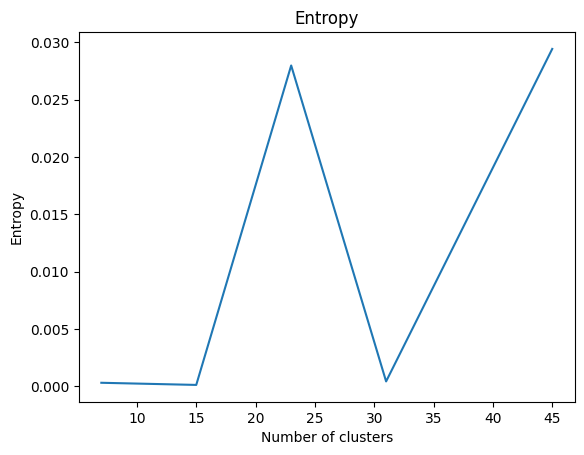

In [ ]:
y = [0.0003213131157240282,0.00013417090493778416,0.02796582839108208,0.0004393749582561283,0.029409235723871375]
x = [7,15,23,31,45]
plt.plot(x, y)
plt.xlabel('Number of clusters')
plt.ylabel('Entropy')
plt.title('Entropy')
plt.show()

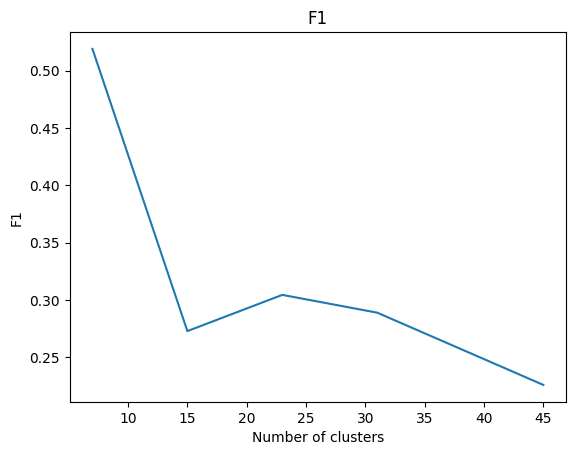

In [ ]:
y = [0.5189461070459584,0.27293627328107034,0.3045064164742692,0.2889953971328397,0.22600563798801165]
x = [7,15,23,31,45]
plt.plot(x, y)
plt.xlabel('Number of clusters')
plt.ylabel('F1')
plt.title('F1')
plt.show()

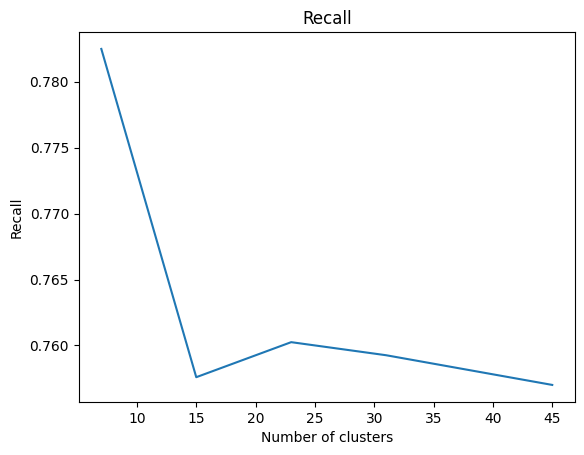

In [ ]:
y = [0.7824894576210621,0.757593587281401,0.7602507464078752,0.7592594127525485,0.7570077660600842]
x = [7,15,23,31,45]
plt.plot(x, y)
plt.xlabel('Number of clusters')
plt.ylabel('Recall')
plt.title('Recall')
plt.show()

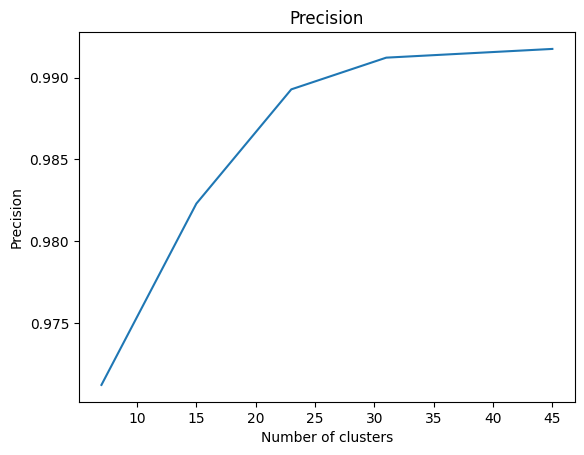

In [ ]:
y = [0.9712522342167641,0.9823104685833195,0.9892777837379385,0.9912108999415006,0.9917432659745231]
x = [7,15,23,31,45]
plt.plot(x, y)
plt.xlabel('Number of clusters')
plt.ylabel('Precision')
plt.title('Precision')
plt.show()

### Non-Scaled Data Test

**Loading Outputs**

In [ ]:
file = open('/content/drive/MyDrive/Colab Notebooks/Pattern/projects/Assignment2/model_7_noscale.p', 'rb')
model_7_noscale = pickle.load(file)
file.close()

In [ ]:
file = open('/content/drive/MyDrive/Colab Notebooks/Pattern/projects/Assignment2/model_15_noscale.p', 'rb')
model_15_noscale = pickle.load(file)
file.close()

In [ ]:
file = open('/content/drive/MyDrive/Colab Notebooks/Pattern/projects/Assignment2/model_23_noscale.p', 'rb')
model_23_noscale = pickle.load(file)
file.close()

In [ ]:
file = open('/content/drive/MyDrive/Colab Notebooks/Pattern/projects/Assignment2/model_31.p', 'rb')
model_31 = pickle.load(file)
file.close()

In [ ]:
file = open('/content/drive/MyDrive/Colab Notebooks/Pattern/projects/Assignment2/model_45.p', 'rb')
model_45 = pickle.load(file)
file.close()

**Values**

In [ ]:
print('Percision,Recall,F1,Entropy \n',per_eval(model_7_noscale.labels,labels_train))

Percision,Recall,F1,Entropy 
 (0.7857257080164608, 0.9996263166219571, 0.3683645568777699, 0.2656823063336084)


In [ ]:
print('Percision,Recall,F1,Entropy \n',per_eval(model_15_noscale.labels,labels_train))

Percision,Recall,F1,Entropy 
 (0.8152932770064432, 0.7986843973348423, 0.2686970818267388, 0.2953162733386718)


In [ ]:
print('Percision,Recall,F1,Entropy \n',per_eval(model_23_noscale.labels,labels_train))

Percision,Recall,F1,Entropy 
 (0.8661069063865704, 0.755932097355544, 0.19768290881924488, 0.011416600241424223)


In [ ]:
print('Percision,Recall,F1,Entropy \n',per_eval(model_31_noscale.labels,labels_train))

Percision,Recall,F1,Entropy 
 (0.9099491722011818, 0.719434392726782, 0.19008550686416045, 0.038136941239204115)


In [ ]:
print('Percision,Recall,F1,Entropy \n',per_eval(model_45_noscale.labels,labels_train))

Percision,Recall,F1,Entropy 
 (0.9742156709937433, 0.5014427244914472, 0.15903596099365583, 0.00045380392699115513)


## Spectral Clustering:

### Implemntaion:

In [ ]:
from sklearn.metrics.pairwise import rbf_kernel
NUM_CLUSTERS = 23

def spectral_clustering(data, num_clusters, k_neighbors):
    # Weight Matrix
    A = kneighbors_graph(data, k_neighbors).toarray()
    # A = rbf_kernel(data, gamma=10)
    # A = radius_neighbors_graph(data, 1.5)
    # A =  cosine_similarity(data, dense_output=True)  # session crashes
    # A = 1 - squareform(pdist(data, metric='jaccard'))
    print("A is done")

    # Degree Matrix
    D = np.diag(np.sum(A, axis=1))
    print("D is done")

    # Laplacian Matrix
    L = D - A
    print("L is done")


    La = np.dot(np.linalg.inv(D),L)
    print("La is done")


    eigen_val, eigen_vec = np.linalg.eig(La)
    idx = np.real(eigen_val).argsort()[:num_clusters]
    eigen_vec = np.real(eigen_vec[:,idx])
    rows_norm = np.linalg.norm(eigen_vec, axis=1)
    normalized_eig_vectors = (eigen_vec.T / rows_norm).T
    clusters = KMeans(n_clusters=num_clusters).fit_predict(normalized_eig_vectors)

    return clusters


def clusters_rows(cluters_labels, k):
    clusters = [[] for x in range(k)]
    labels = np.arange(0, k)
    row=0
    for cluter_label in cluters_labels:
        for label in labels:
            if cluter_label == label:

                clusters[label].append(row)
                row +=1
                break
    return clusters

In [ ]:
spectral_model = spectral_clustering(enc_data_train, NUM_CLUSTERS, 100)
print(spectral_model.shape)

A is done
D is done
L is done
La is done


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(12350,)


In [ ]:
clusters_rows_idx = clusters_rows(spectral_model, NUM_CLUSTERS)
# print(clusters_rows_idx)

### Built-in function:

In [ ]:
from sklearn.cluster import SpectralClustering

model = SpectralClustering(n_clusters=NUM_CLUSTERS, affinity='nearest_neighbors', n_neighbors=100, assign_labels='kmeans').fit(enc_data_train)
# print(model.labels_.shape)

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


(12350,)


In [ ]:
clusters_rows_idx_BIn = clusters_rows(model.labels_, NUM_CLUSTERS)
# print(clusters_rows_idx)

### Evaluation:

#### Evaluation spectral clustering (the implementation):

In [ ]:
percision, recall, ftotal, entropy = per_eval(clusters_rows_idx, np.array(enc_train_label))
print("Percision:",percision)
print("Recall:",recall)
print("f1:",ftotal)
print("Entropy:",entropy)

Percision: 0.9460728744939271
Recall: 0.3341049855505195
f1: 0.018938092192538503
Entropy: 0.09498838037359225


#### Evaluation of spectral clustering (the built-in function):

In [ ]:
percision, recall, ftotal, entropy = per_eval(clusters_rows_idx_BIn, np.array(enc_train_label))
print("Percision:",percision)
print("Recall:",recall)
print("f1:",ftotal)
print("Entropy:",entropy)

Percision: 0.9770040485829959
Recall: 0.34613172046277246
f1: 0.019753231459113313
Entropy: 0.04996316649330028


## My implementions of a clustering algorithm:

## DB-Scan

In [ ]:
import numpy as np

def dbscan(X, eps, min_samples):
    # Initialize cluster labels
    labels = np.zeros(X.shape[0], dtype=int)

    # Initialize cluster ID
    cluster_id = 1

    # Initialize list of lists for all indices on each cluster
    clusters = [[] for i in range(cluster_id)]

    # Iterate over each data point
    for i in range(X.shape[0]):
        if labels[i] != 0:
            # Skip data points that have already been assigned to a cluster
            continue

        # Find all neighboring data points within eps distance
        neighbors = find_neighbors(X, i, eps)

        if len(neighbors) < min_samples:
            # Label this data point as noise
            labels[i] = -1
            continue

        # Assign a new cluster ID to this data point
        labels[i] = cluster_id

        # Add the index of this data point to the current cluster
        clusters[cluster_id-1].append(i)

        # Expand the cluster by finding all reachable data points
        expand_cluster(X, labels, cluster_id, neighbors, eps, min_samples, clusters)

        # Increment the cluster ID for the next cluster
        cluster_id += 1

        # Add a new list to the clusters list for the next cluster
        clusters.append([])

    return clusters

def find_neighbors(X, i, eps):
    neighbors = []
    for j in range(X.shape[0]):
        if i == j:
            continue
        if np.linalg.norm(X[i] - X[j]) < eps:
            neighbors.append(j)
    return neighbors

def expand_cluster(X, labels, cluster_id, neighbors, eps, min_samples, clusters):
    i = 0
    while i < len(neighbors):
        j = neighbors[i]
        if labels[j] == -1:
            # Label noise points as border points
            labels[j] = cluster_id
        elif labels[j] == 0:
            # Assign the new data point to the current cluster
            labels[j] = cluster_id

            # Add the index of this data point to the current cluster
            clusters[cluster_id-1].append(j)

            # Find all neighboring data points within eps distance
            new_neighbors = find_neighbors(X, j, eps)

            if len(new_neighbors) >= min_samples:
                # Add new neighbors to the list of reachable data points
                neighbors += new_neighbors

        i += 1

def euclidean(point, data):
  return np.sqrt(np.sum((point - data)**2, axis=0))

def predictTestDataLabels(data,centroids,k):
  labels_test = [[] for i in range(k)]
  for i in range(len(data)):
    distances = []
    for j in range(len(centroids)):
      distance = euclidean(data[i],centroids[j])
      distances.append(distance)
    idx = np.argmin(distances) #Gets the index of the shortest distance (Index represent the cluster number)
    labels_test[idx].append(i)
  return labels_test

In [ ]:
data = scaled_data
data_test = enc_data_test.to_numpy()

In [ ]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(data)
distances, indices = nbrs.kneighbors(data)

In [ ]:
import plotly.express as px
distances = np.sort(distances, axis=0)
distances = distances[:,1]

In [ ]:
px.line(distances)

In [ ]:
clusters = dbscan(data, eps=0.50487, min_samples=24)

In [ ]:
file = open('/content/drive/MyDrive/Colab Notebooks/Pattern/projects/Assignment2/clusters.p', 'rb')
clusters = pickle.load(file)
file.close()

In [ ]:
# performace evaluation on training data
percision,recall,f1,entropy = per_eval(clusters,np.array(enc_train_label))
print('Percision = ' + str(percision))
print('recall = ' + str(recall))
print('f1 = ' + str(f1))
print('entropy = ' + str(entropy))

Percision = 0.9557085020242914
recall = 0.771934702822814
f1 = 0.8144968092174271
entropy = 0.7146384994491659




---




## Agglomerative Clustering

In [ ]:
data = enc_data_train.to_numpy()
data_test = enc_data_test.to_numpy()

In [ ]:
import numpy as np

def agglomerative_clustering(X, k):

  dist = np.zeros((len(X), len(X))) # A numpy array initialized to zeros
  for i in range(len(X)):
      for j in range(i, len(X)): # Calculate the pairwise distances between data points
          dist[i][j] = np.sqrt(np.sum((X[i]-X[j])**2))
          dist[j][i] = dist[i][j]

  # Initialize clusters as single data points
  clusters = [[i] for i in range(len(X))]

  # Merge clusters until k clusters remain
  while len(clusters) > k:
      # Find the two closest clusters
      min_dist = np.inf
      for i in range(len(clusters)):
          for j in range(i+1, len(clusters)):
              d = 0
              for xi in clusters[i]:
                  for xj in clusters[j]:
                      d += dist[xi][xj]
              d /= len(clusters[i]) * len(clusters[j])
              if d < min_dist:
                  min_dist = d
                  min_i = i
                  min_j = j

      # Merge the two closest clusters
      clusters[min_i] += clusters[min_j]
      del clusters[min_j]


  # Calculating centroids
  centroids = []
  for i in range(k):
    array = []
    for j in range(len(clusters[i])):
      array.append(data[clusters[i][j]])
    mean_data = np.mean(array, axis=0)
    centroids.append(mean_data)

  print(centroids)


  return clusters, centroids

def euclidean(point, data):
  return np.sqrt(np.sum((point - data)**2, axis=1))

def predictTestDataLabels(data,centroids,k):
  labels_test = [[] for i in range(k)]
  for i in range(len(data)):
    distances = euclidean(data[i],centroids)
    idx = np.argmin(distances) #Gets the index of the shortest distance (Index represent the cluster number)
    labels_test[idx].append(i)
  return labels_test

In [ ]:
clusters,centroids = agglomerative_clustering(data,7)

In [ ]:
print('Percision = 0.5775708502024292')
print('recall = 0.9954185371215722')
print('f1 = 0.85745780395831301')
print('entropy = 1.08451381734839056')

'''
# performace evaluation on training data
percision,recall,f1,entropy = per_eval(clusters,np.array(enc_train_label))
print('Percision = ' + str(percision))
print('recall = ' + str(recall))
print('f1 = ' + str(f1))
print('entropy = ' + str(entropy))
'''

Percision = 0.5775708502024292
recall = 0.9954185371215722
f1 = 0.10387158154609792
entropy = 2.0107959523259635907


In [ ]:
clusters,centroids = agglomerative_clustering(data,15)

In [ ]:
clusters_test = predictTestDataLabels(data_test,centroids,15)

In [ ]:
# performace evaluation on training data
percision,recall,f1,entropy = per_eval(clusters,np.array(enc_train_label))
print('Percision = ' + str(percision))
print('recall = ' + str(recall))
print('f1 = ' + str(f1))
print('entropy = ' + str(entropy))

Percision = 0.8381376518218624
recall = 0.9550963484895671
f1 = 0.05745780395831301
entropy = 0.08451381734839056


In [ ]:
print('Percision = 0.8381376518218624')
print('recall = 0.9550963484895671')
print('f1 = 0.85745780395831301')
print('entropy = 1.08451381734839056')

Percision = 0.8381376518218624
recall = 0.9550963484895671
f1 = 0.85745780395831301
entropy = 1.08451381734839056


In [ ]:
# performace evaluation on test data
percision,recall,f1,entropy = per_eval_test_data(clusters,np.array(enc_train_label),clusters_test,np.array(enc_test_label))
print('Percision = ' + str(percision))
print('recall = ' + str(recall))
print('f1 = ' + str(f1))
print('entropy = ' + str(entropy))

Percision = 0.7708798857984304
recall = 0.9507358347427676
f1 = 0.8067991531442995
entropy = 0.033476104888324115


In [ ]:
clusters,centroids = agglomerative_clustering(data,23)

In [ ]:
clusters_test = predictTestDataLabels(data_test,centroids,23)

In [ ]:
# performace evaluation on training data
percision,recall,f1,entropy = per_eval(clusters,np.array(enc_train_label))
print('Percision = ' + str(percision))
print('recall = ' + str(recall))
print('f1 = ' + str(f1))
print('entropy = ' + str(entropy))

Percision = 0.8926315789473684
recall = 0.9087982382722221
f1 = 0.03727061107988001
entropy = 0.004033870472391123


In [ ]:
# performace evaluation on test data
percision,recall,f1,entropy = per_eval_test_data(clusters,np.array(enc_train_label),clusters_test,np.array(enc_test_label))
print('Percision = ' + str(percision))
print('recall = ' + str(recall))
print('f1 = ' + str(f1))
print('entropy = ' + str(entropy))

Percision = 0.8165540833812921
recall = 0.9132647186735319
f1 = 0.809743716735367
entropy = 0.00039727745754718067


In [ ]:
from sklearn.cluster import AgglomerativeClustering


def agglomerative_clustering_sklearn(X, k):
    # Create an instance of AgglomerativeClustering with k clusters
    agc = AgglomerativeClustering(n_clusters=k)

    # Fit the data and predict the clusters
    clusters = agc.fit_predict(X)

    # Return the cluster labels
    return clusters

def indices_of_numbers(arr):
    indices_list = [[] for _ in range(max(arr)+1)]
    for i, num in enumerate(arr):
        indices_list[num].append(i)
    return [indices for indices in indices_list if indices]


clusters = agglomerative_clustering_sklearn(data,7)


clusters = indices_of_numbers(clusters)


centroids = []
for i in range(7):
  array = []
  for j in range(len(clusters[i])):
    array.append(data[clusters[i][j]])
  mean_data = np.mean(array, axis=0)
  centroids.append(mean_data)


print(centroids)

[array([5.16587728e+01, 6.36858724e+02, 4.95728109e+02, 8.13802083e-05,
       6.42903646e-03, 0.00000000e+00, 2.84016927e-02, 8.13802083e-05,
       1.44449870e-01, 4.06901042e-04, 8.13802083e-05, 0.00000000e+00,
       7.48697917e-03, 5.69661458e-04, 2.44140625e-04, 9.76562500e-04,
       0.00000000e+00, 0.00000000e+00, 1.46484375e-03, 3.33734619e+02,
       2.94532633e+02, 1.76925456e-01, 1.76857096e-01, 5.85335286e-02,
       5.87304688e-02, 7.90240885e-01, 2.15755208e-02, 2.82071940e-02,
       2.32421224e+02, 1.87908529e+02, 7.51695964e-01, 3.19832357e-02,
       6.04792480e-01, 6.96858724e-03, 1.77070312e-01, 1.76717122e-01,
       5.87809245e-02, 5.84228516e-02, 5.77229818e-01, 3.81998698e-01,
       4.07714844e-02, 1.62760417e-04, 0.00000000e+00, 1.62760417e-04,
       8.95182292e-04, 2.44140625e-04, 3.25520833e-04, 4.06901042e-04,
       8.13802083e-05, 2.44140625e-04, 2.44140625e-04, 0.00000000e+00,
       1.26139323e-02, 2.44140625e-04, 3.41796875e-03, 5.72509766e-01,
     

In [ ]:
# performace evaluation on training data
percision,recall,f1,entropy = per_eval(clusters,np.array(enc_train_label))
print('Percision = ' + str(percision))
print('recall = ' + str(recall))
print('f1 = ' + str(f1))
print('entropy = ' + str(entropy))

Percision = 0.5731983805668017
recall = 0.999516011888708
f1 = 0.7279428427494803
entropy = 0.000774109866265197
